In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
import time
import warnings
warnings.filterwarnings('ignore')
import importlib #importlib.reload(my_module)
from functions import *

In [2]:
import scipy.io
mat = scipy.io.loadmat('./data/Cardiac_DE_2.mat')

In [3]:
A = mat['X'][:,:,0]
N = np.array(A.shape)

In [4]:
N

array([256, 176])

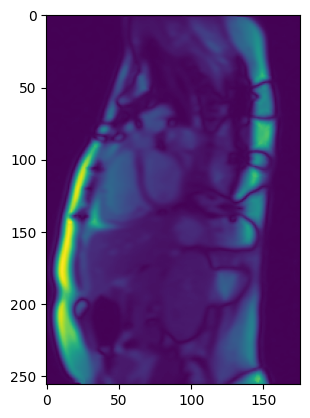

In [5]:
plt.imshow(A)
plt.show()

In [78]:
r = 20
p = 0.5
q = 0.5

In [79]:
Q, Cr, P, rows, cols = SCSVD(A,r,p,q)

In [85]:
N

array([256, 176])

In [86]:
np.log(0.1)

-2.3025850929940455

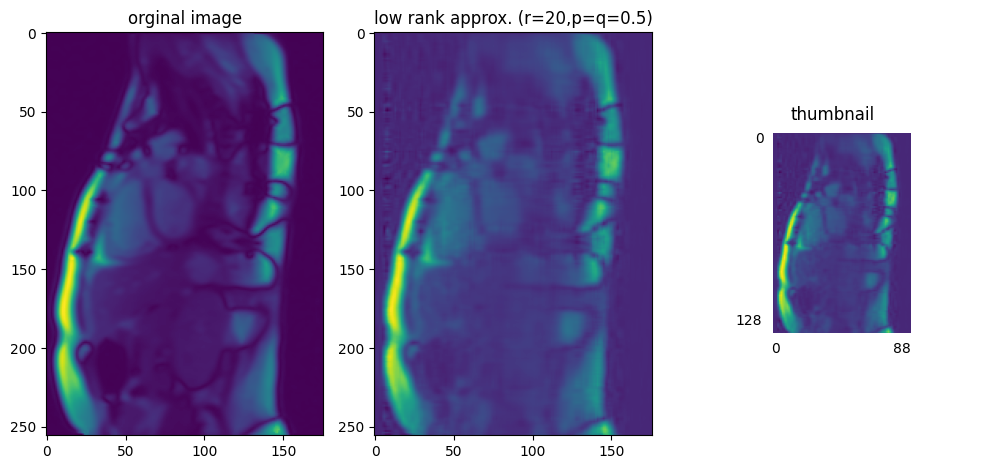

In [84]:
fig, ax = plt.subplots(1,3,figsize=[10,5])
ax[0].imshow(A)
ax[0].set_aspect('equal')
ax[0].set_title('orginal image')

Ahat = Q.dot(Cr).dot(P.T)
ax[1].imshow(Ahat)
ax[1].set_aspect('equal')
ax[1].set_title(f'low rank approx. (r={r},p=q={p})')

thumbnail = np.full_like(A,np.nan)
rows = np.arange(0,N[0],2)
cols = np.arange(0,N[1],2)
origin = [int(N[0]/2 - len(rows)/2),int(N[1]/2 - len(cols)/2)]
lr = origin[0]
ur = lr + len(rows)
lc = origin[1]
uc = lc + len(cols)
thumbnail[lr:ur,lc:uc] = Q[rows,:].dot(Cr).dot(P[cols,:].T)
ax[2].imshow(thumbnail)
ax[2].set_aspect('equal')
ax[2].axis('off')

ax[2].annotate('thumbnail',(55,55),fontsize=12)
ax[2].annotate('0',(33,70))
ax[2].annotate(f'{len(rows)}',(20,185))
ax[2].annotate('0',(43,203))
ax[2].annotate(f'{len(cols)}',(120,203))
plt.tight_layout()
plt.savefig('plots/thumbnail_ACML.png',dpi=300)
plt.show()

# Random sampling

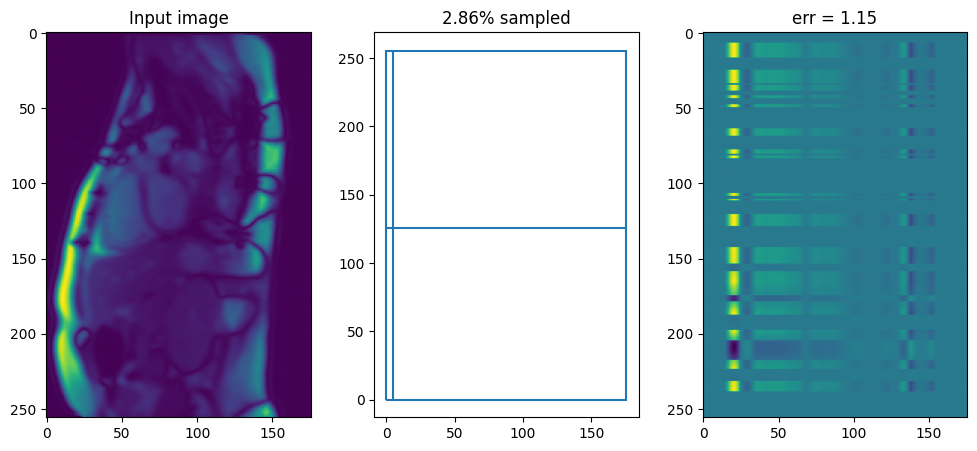

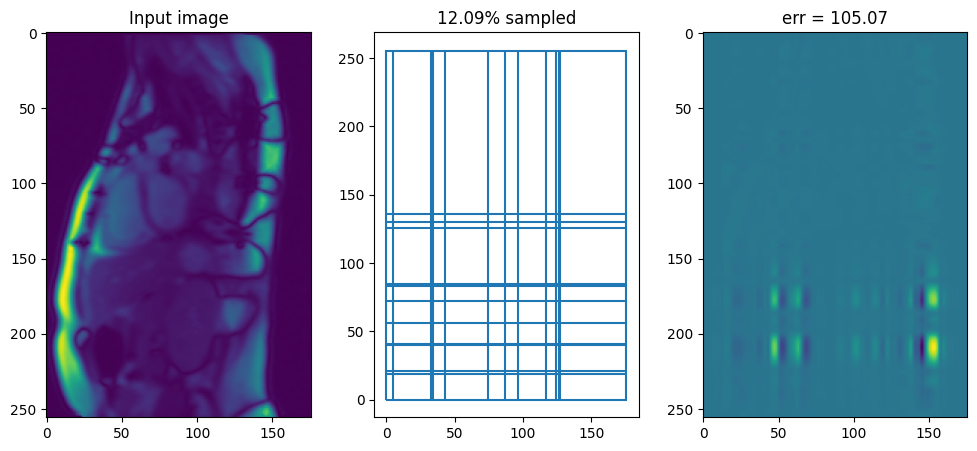

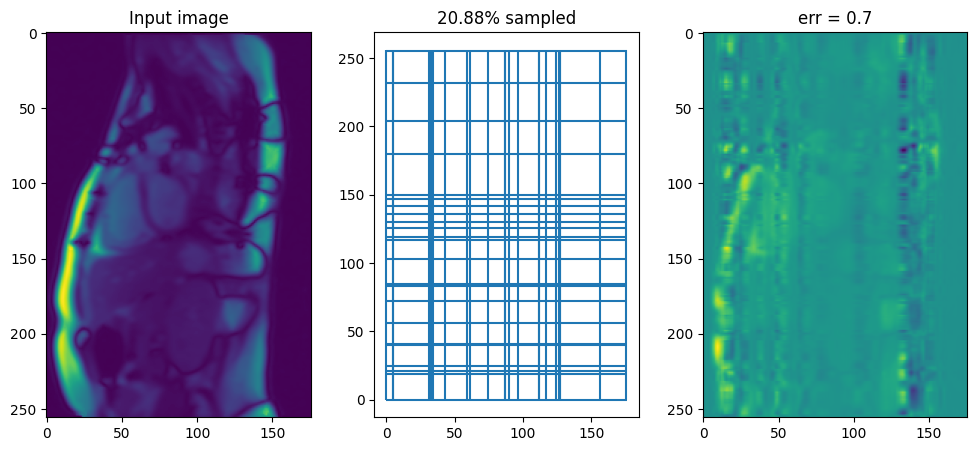

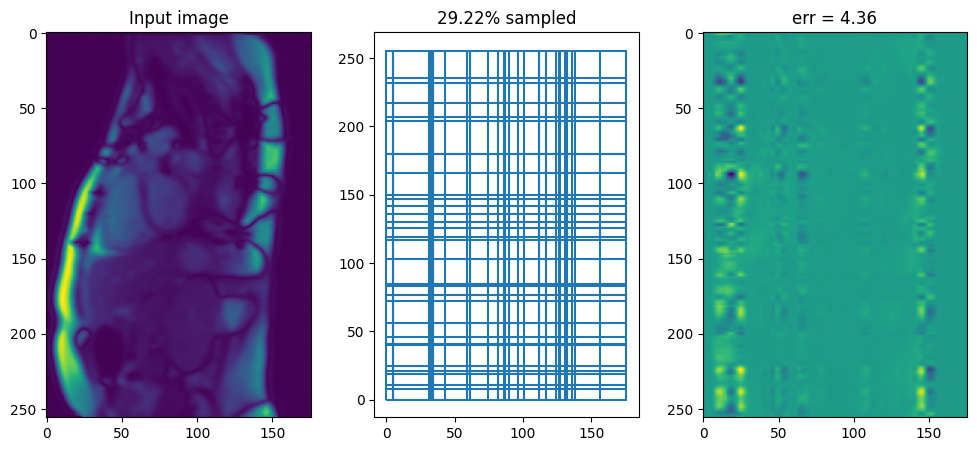

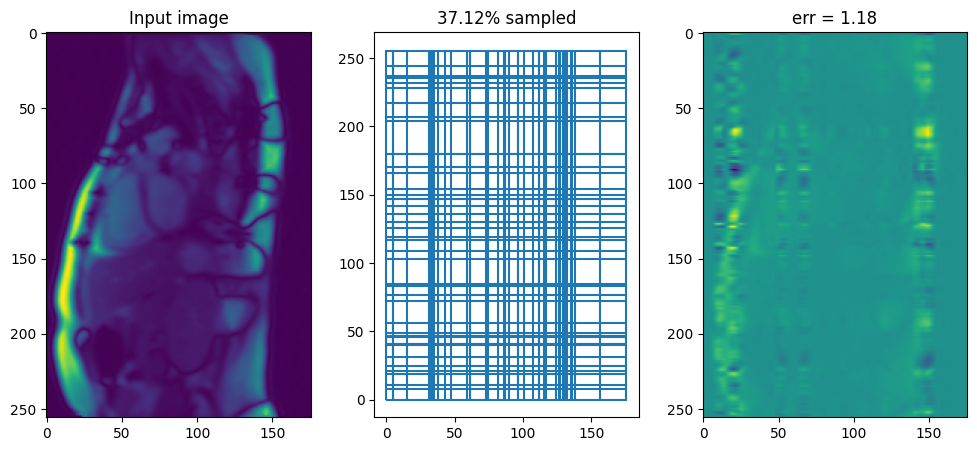

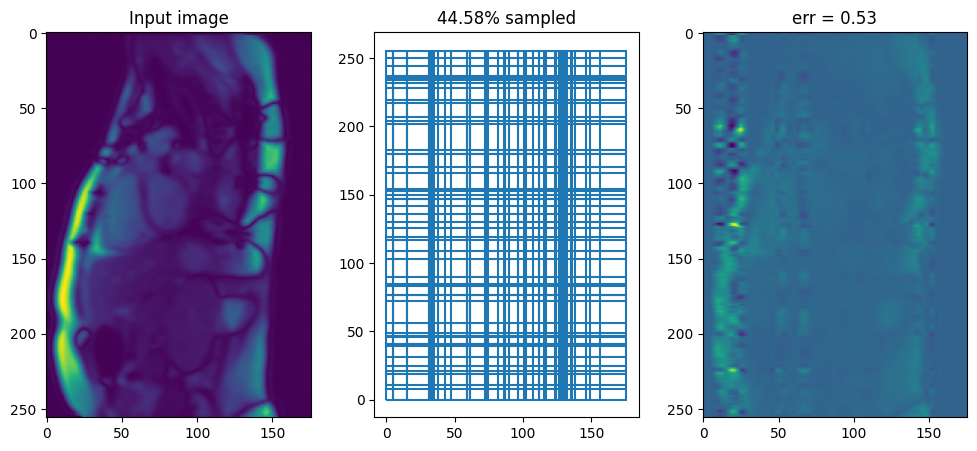

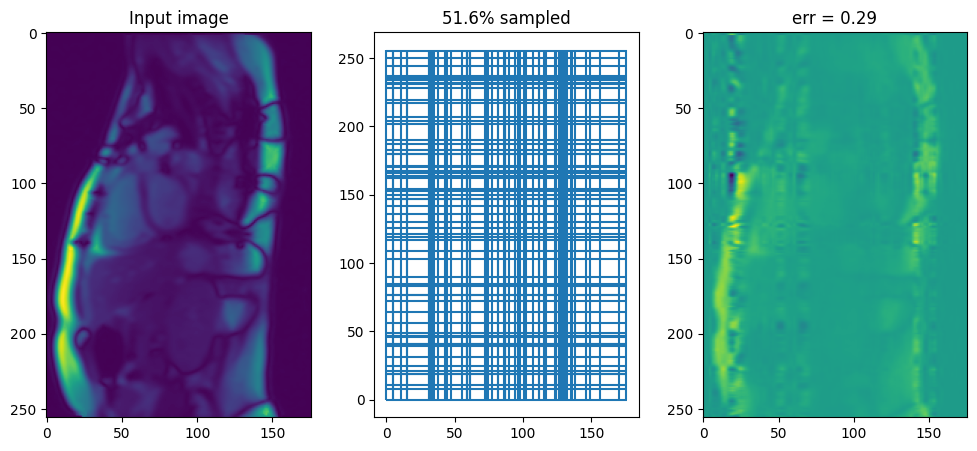

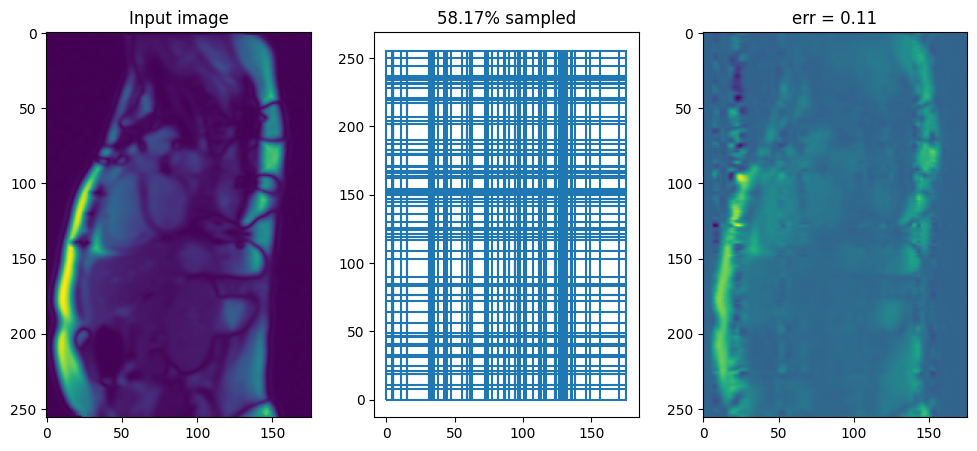

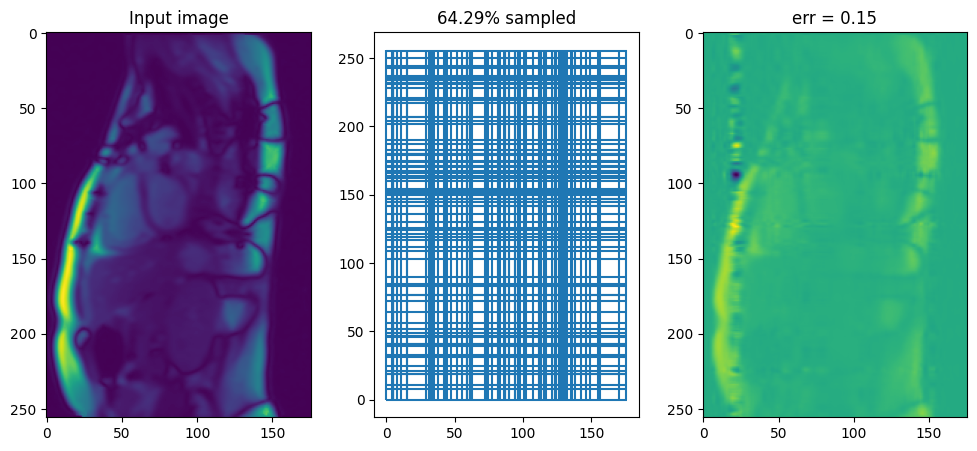

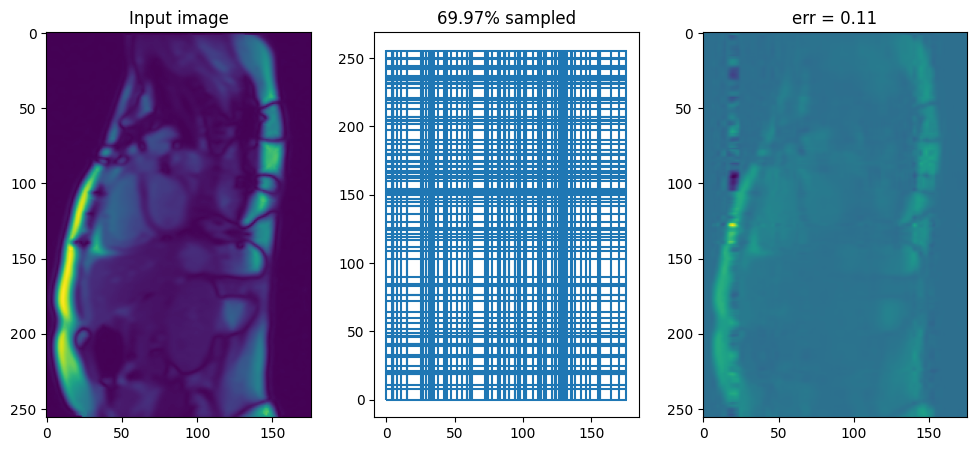

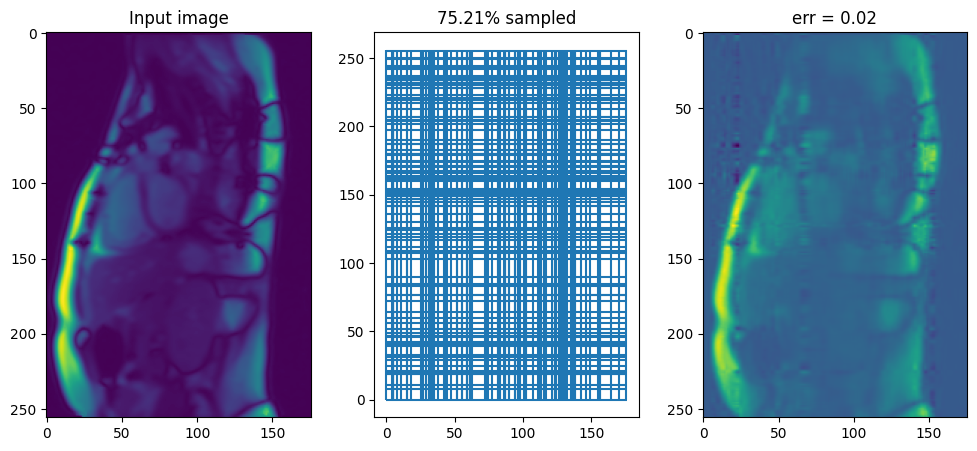

In [26]:
sampled_row = np.array([0,N[0]-1])
sampled_col = np.array([0,N[1]-1])
unsampled_row = np.arange(1,N[0]-1)
unsampled_col = np.arange(1,N[1]-1)

log_r = [[],[]]
for i in range(101):
    row = choice(unsampled_row,1)
    col = choice(unsampled_col,1)

    sampled_row = np.sort(np.append(sampled_row,row))
    sampled_col = np.sort(np.append(sampled_col,col))

    m = min([len(sampled_row),len(sampled_col)])
    if np.any(m < r):
        k = m
        s = m
    else:
        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)
    m = np.array([len(sampled_row),len(sampled_col)])

    Map = normal(size=(k,m[0]))
    Map_T = normal(size=(m[1],k))
    MapL = normal(size=(s,m[0]))
    MapR = normal(size=(s,m[1]))

    X = Map @ A[sampled_row,:]
    Y = A[:,sampled_col] @ Map_T
    Z = MapL @  A[np.ix_(sampled_row,sampled_col)] @ MapR.T

    P, _ = qr(np.array(X.T))
    Q, _ = qr(np.array(Y))

    C = pinv(MapL @ Q[sampled_row,:]).dot(Z).dot(pinv(MapR @ P[sampled_col,:]).T)
    U, s, VT = svd(C)
    Cr = U[:,:r].dot(np.diag(s[:r])).dot(VT[:r,:])
    
    sampled_size = A[sampled_row,:].size + A[:,sampled_col].size -  A[np.ix_(sampled_row,sampled_col)].size
    Ar = Q.dot(Cr).dot(P.T)
    err = norm(A - Ar)**2 / norm(A)**2
    
    log_r[0].append(sampled_size/A.size)
    log_r[1].append(err)
    
    if i % 10  == 0:
        fig, ax = plt.subplots(1,3,figsize=[12,5])
        ax[0].imshow(A)
        ax[0].set_title('Input image')

        ax[1].vlines(sampled_col,0,N[0])
        ax[1].hlines(sampled_row,0,N[1])
        ax[1].set_aspect('equal')
        ax[1].set_title(f'{np.round(100*sampled_size/A.size,2)}% sampled')

        ax[2].imshow(Ar)
        ax[2].set_title(f'err = {np.round(err,2)}')
        plt.show()

# Progressive sampling

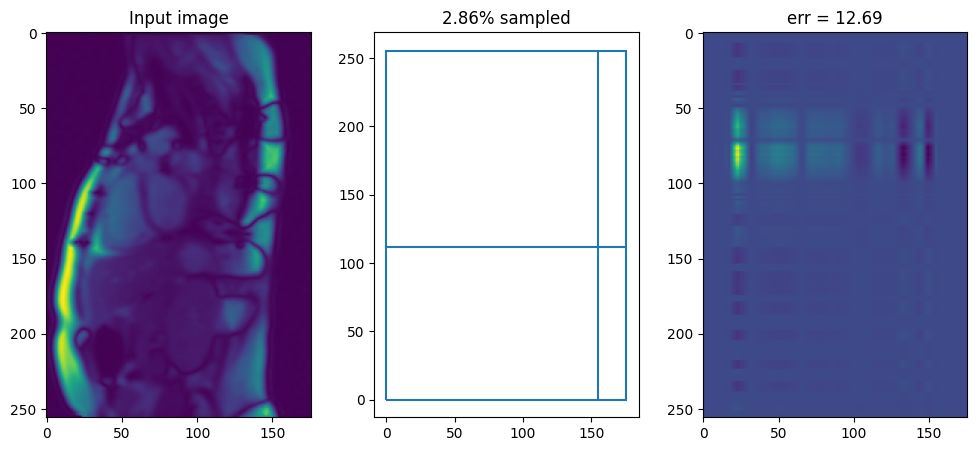

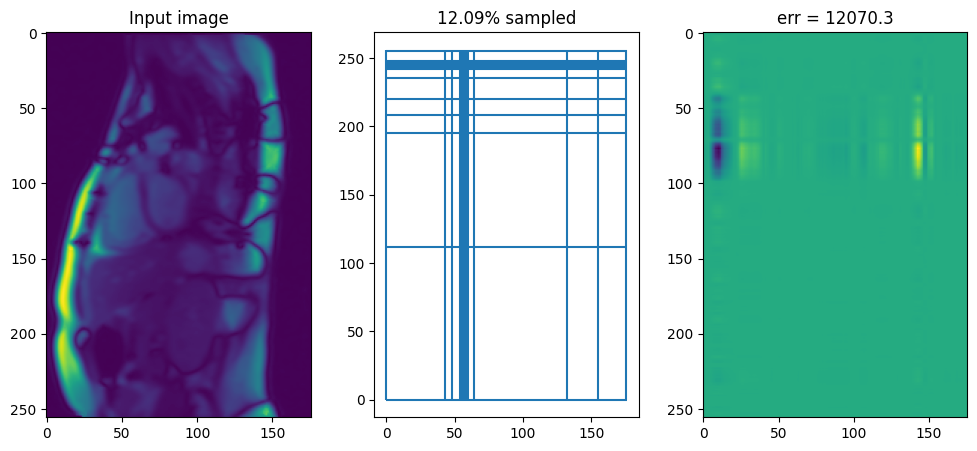

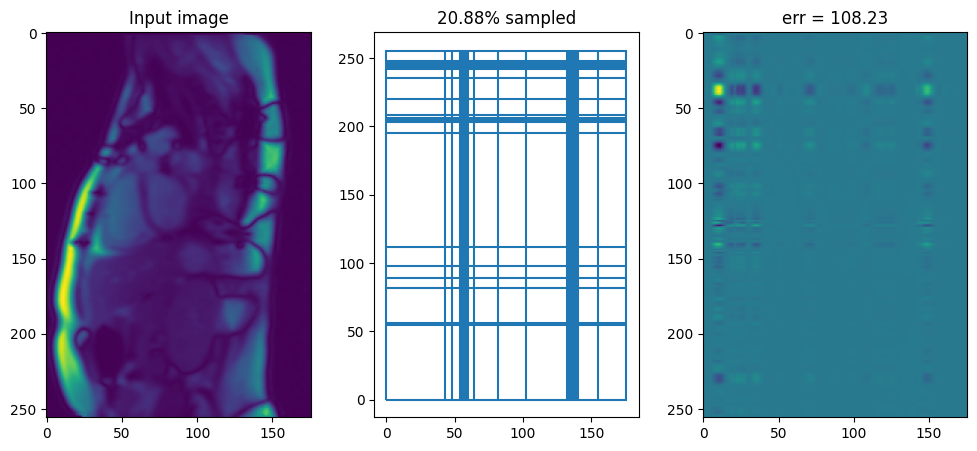

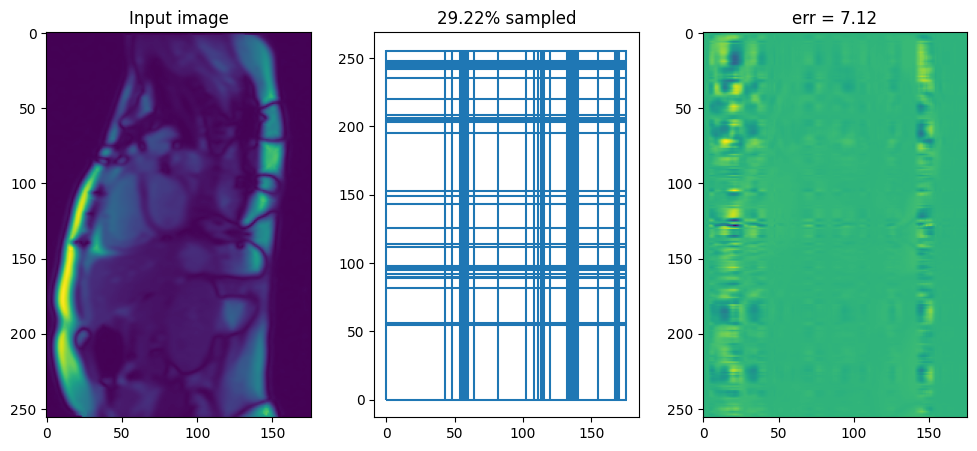

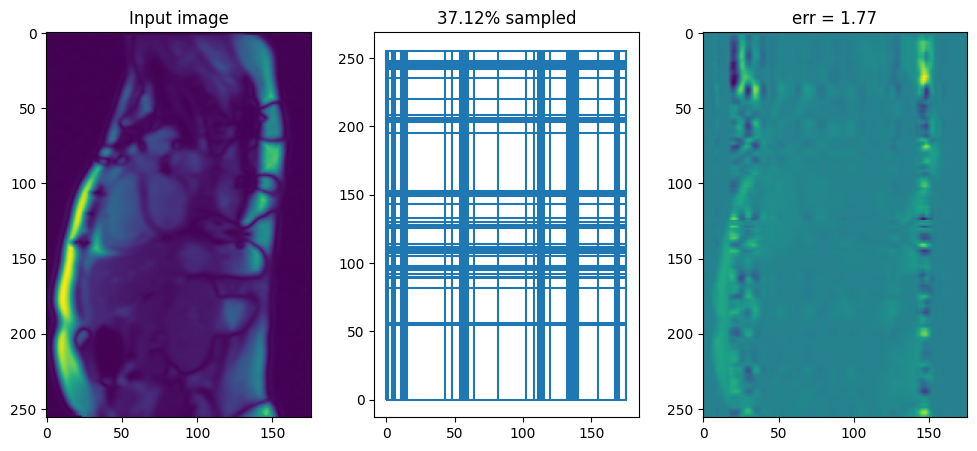

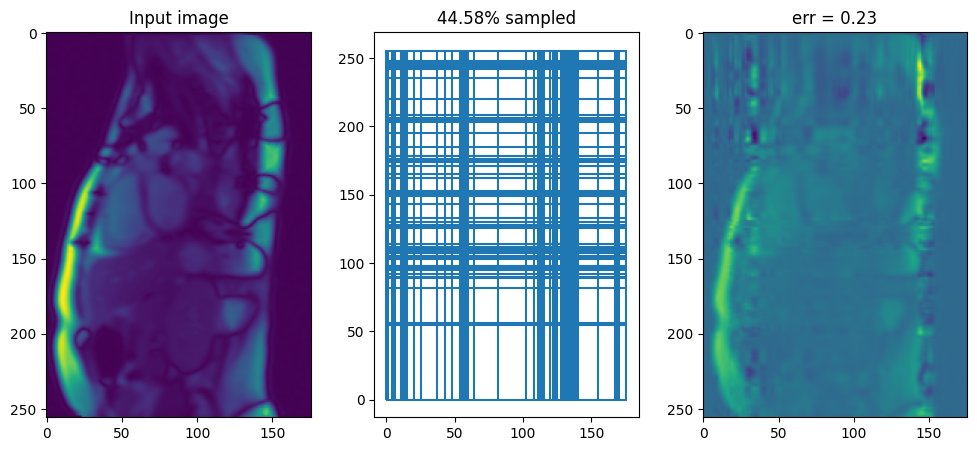

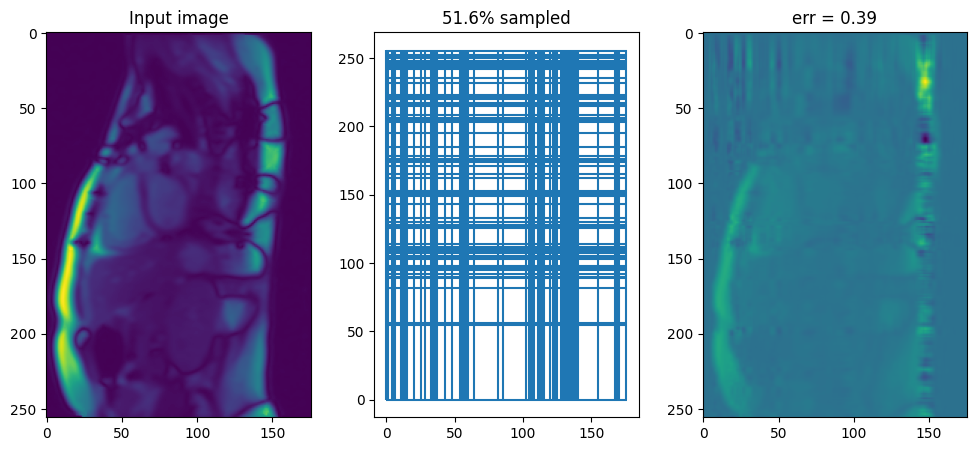

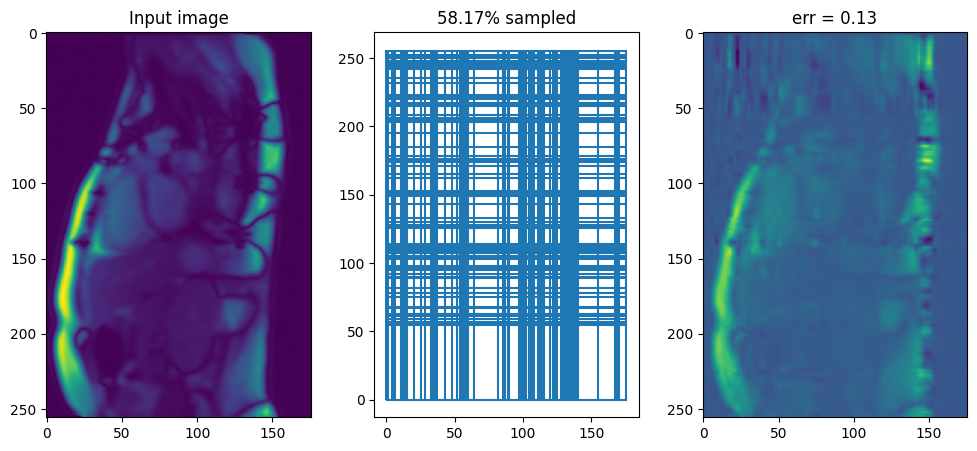

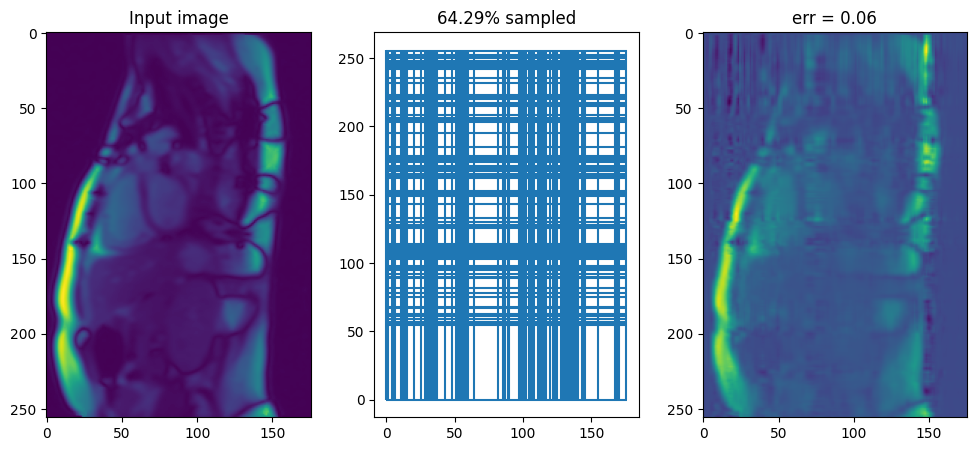

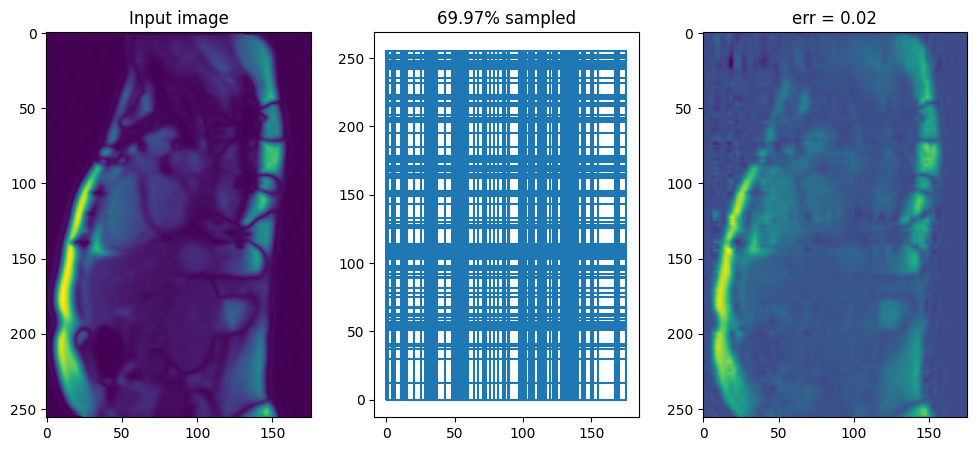

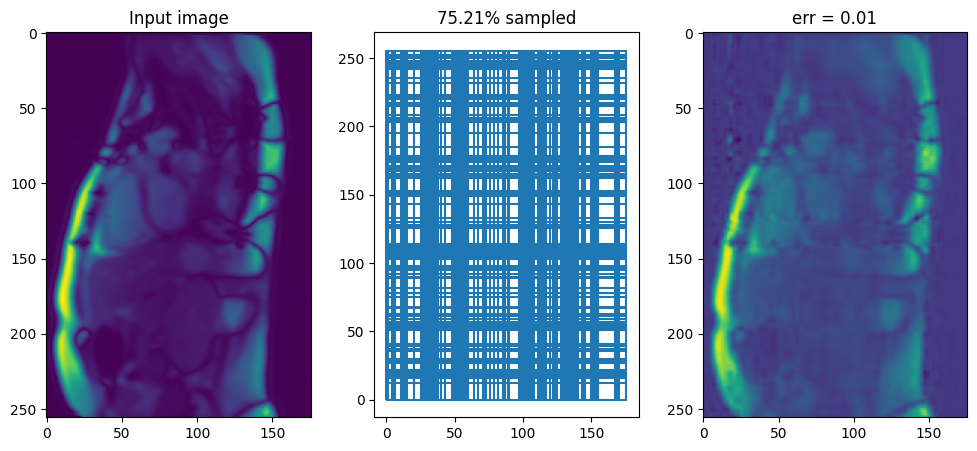

In [25]:
row_space = np.arange(N[0])
col_space = np.arange(N[1])
sampled_row = np.array([0,N[0]-1])
sampled_col = np.array([0,N[1]-1])
sad_row = np.zeros(N[0])
sad_col = np.zeros(N[1])
sad_row[sampled_row] = np.sum(np.abs(np.diff(A[sampled_row,:])),axis=1)/N[1]
sad_col[sampled_col] = np.sum(np.abs(np.diff(A[:,sampled_col],axis=0)),axis=0)/N[0]

f_row = interpolate.interp1d(sampled_row, sad_row[sampled_row])
sad_row = f_row(np.arange(N[0]))
p_row = sad_row
p_row[sampled_row] = 0
if np.sum(p_row) == 0:
    p_row = np.full_like(sad_row,1/N[0])
else:
    p_row = p_row/np.sum(p_row)

f_col = interpolate.interp1d(sampled_col, sad_col[sampled_col])
sad_col = f_col(np.arange(N[1]))
p_col = sad_col
p_col[sampled_col] = 0
if np.sum(p_col) == 0:
    p_col = np.full_like(sad_col,1/N[1])
else:
    p_col = p_col/np.sum(p_col)

log_p = [[],[]]
for i in range(101):
    row = choice(row_space,1,replace=False,p=p_row)
    col = choice(col_space,1,replace=False,p=p_col)
    
    sampled_row = np.sort(np.append(sampled_row,row))
    sampled_col = np.sort(np.append(sampled_col,col))
    
    sad_row[row] = np.sum(np.abs(np.diff(A[row,:])),axis=1)/N[1]
    sad_col[col] = np.sum(np.abs(np.diff(A[:,col],axis=0)),axis=0)/N[0]
    
    f_row = interpolate.interp1d(sampled_row, sad_row[sampled_row])
    sad_row = f_row(np.arange(N[0]))
    p_row = sad_row
    p_row[sampled_row] = 0
    if np.sum(p_row) == 0:
        p_row = np.full_like(sad_row,1/N[0])
    else:
        p_row = p_row/np.sum(p_row)

    f_col = interpolate.interp1d(sampled_col, sad_col[sampled_col])
    sad_col = f_col(np.arange(N[1]))
    p_col = sad_col
    p_col[sampled_col] = 0
    if np.sum(p_col) == 0:
        p_col = np.full_like(sad_col,1/N[1])
    else:
        p_col = p_col/np.sum(p_col)

    m = min([len(sampled_row),len(sampled_col)])
    if np.any(m < r):
        k = m
        s = m
    else:
        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)
    m = np.array([len(sampled_row),len(sampled_col)])
    
    Map = normal(size=(k,m[0]))
    Map_T = normal(size=(m[1],k))
    MapL = normal(size=(s,m[0]))
    MapR = normal(size=(s,m[1]))

    X = Map @ A[sampled_row,:]
    Y = A[:,sampled_col] @ Map_T
    Z = MapL @ A[np.ix_(sampled_row,sampled_col)] @ MapR.T

    P, _ = qr(np.array(X.T))
    Q, _ = qr(np.array(Y))

    C = pinv(MapL @ Q[sampled_row,:]).dot(Z).dot(pinv(MapR @ P[sampled_col,:]).T)
    U, s, VT = svd(C)
    Cr = U[:,:r].dot(np.diag(s[:r])).dot(VT[:r,:])

    sampled_size = A[sampled_row,:].size + A[:,sampled_col].size -  A[np.ix_(sampled_row,sampled_col)].size
    Ar = Q.dot(Cr).dot(P.T)
    err = norm(A - Ar)**2 / norm(A)**2
    
    log_p[0].append(sampled_size/A.size)
    log_p[1].append(err)

    if i % 10  == 0:
        fig, ax = plt.subplots(1,3,figsize=[12,5])
        ax[0].imshow(A)
        ax[0].set_title('Input image')

        ax[1].vlines(sampled_col,0,N[0])
        ax[1].hlines(sampled_row,0,N[1])
        ax[1].set_aspect('equal')
        ax[1].set_title(f'{np.round(100*sampled_size/A.size,2)}% sampled')

        ax[2].imshow(Ar)
        ax[2].set_title(f'err = {np.round(err,2)}')
        plt.show()

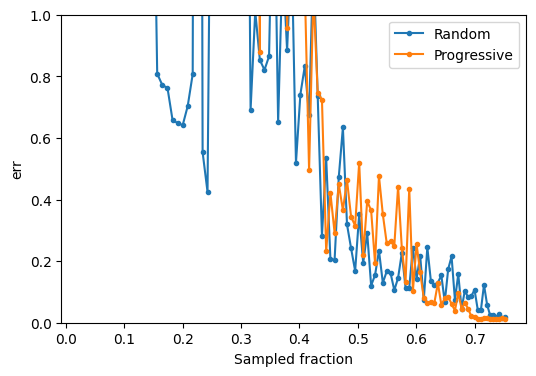

In [27]:
fig, ax = plt.subplots(1,figsize=[6,4])
ax.plot(log_r[0],log_r[1],'.-',label='Random')
ax.plot(log_p[0],log_p[1],'.-',label='Progressive')
ax.set_ylim([0,1])
ax.set_xlabel('Sampled fraction')
ax.set_ylabel('err')
ax.legend()
plt.show()

# Progressive Block Sketching

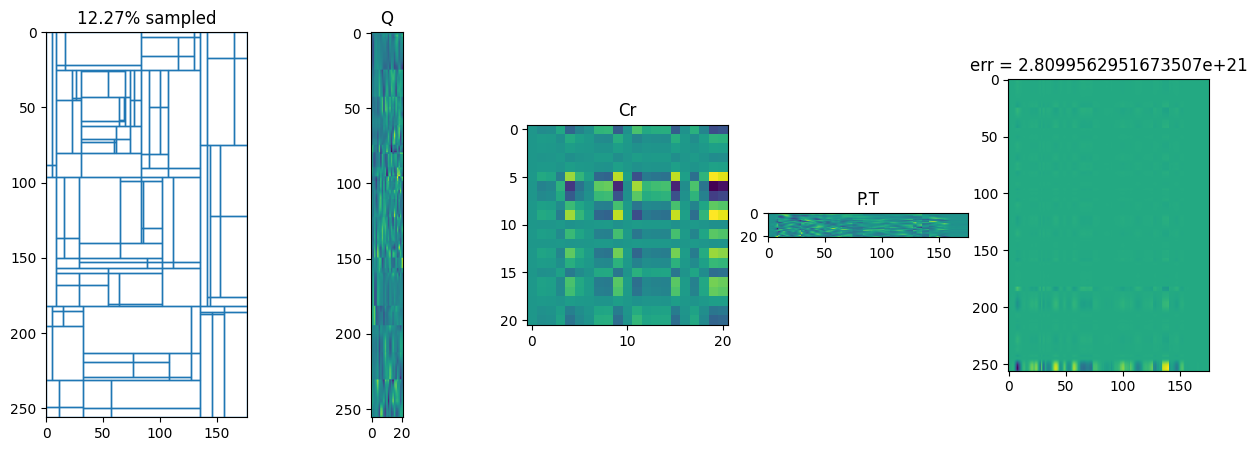

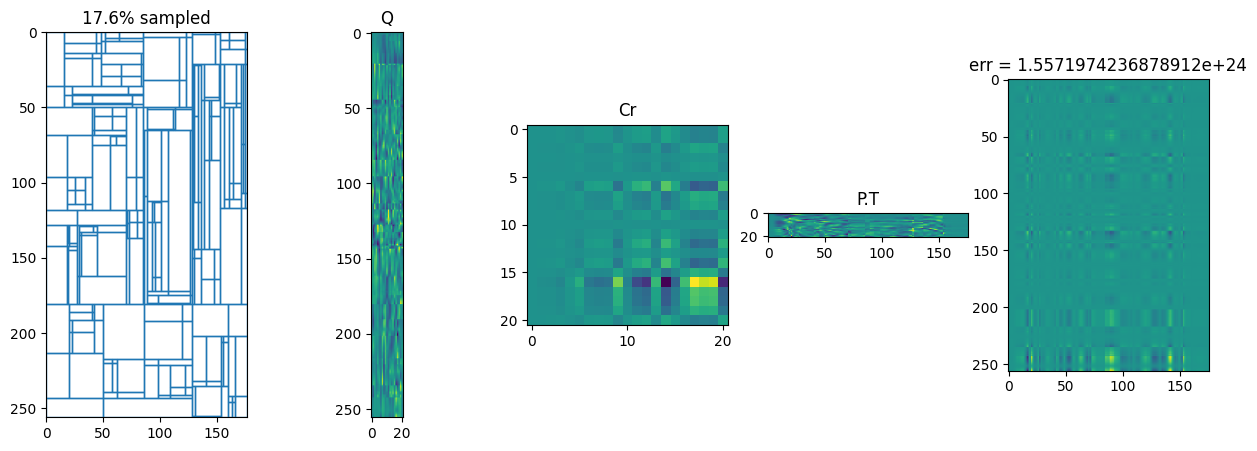

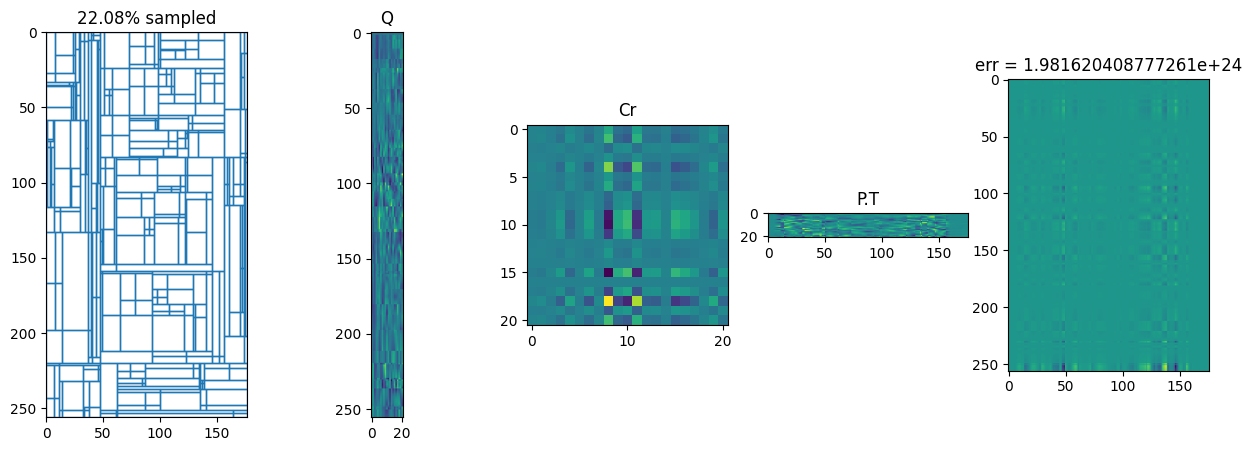

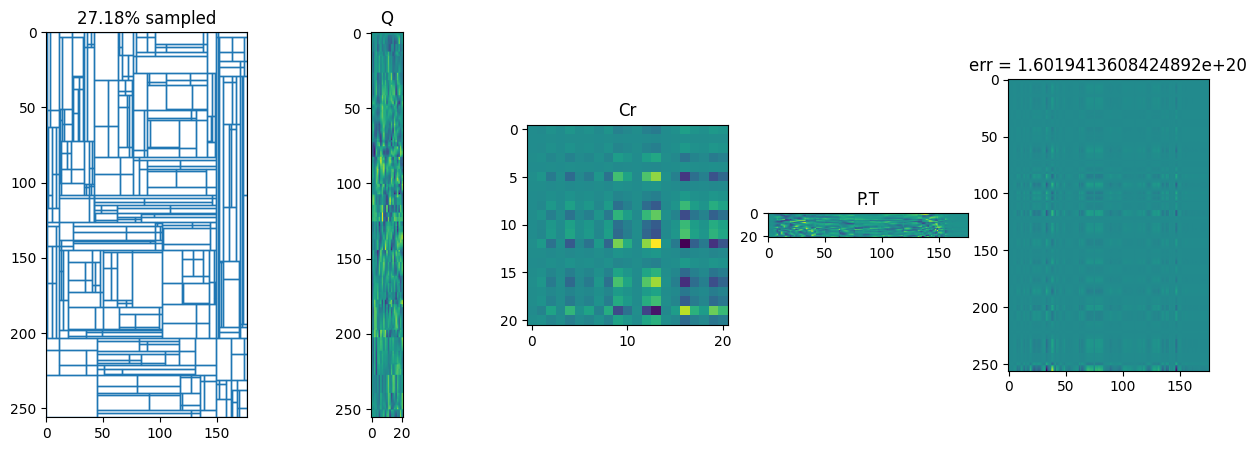

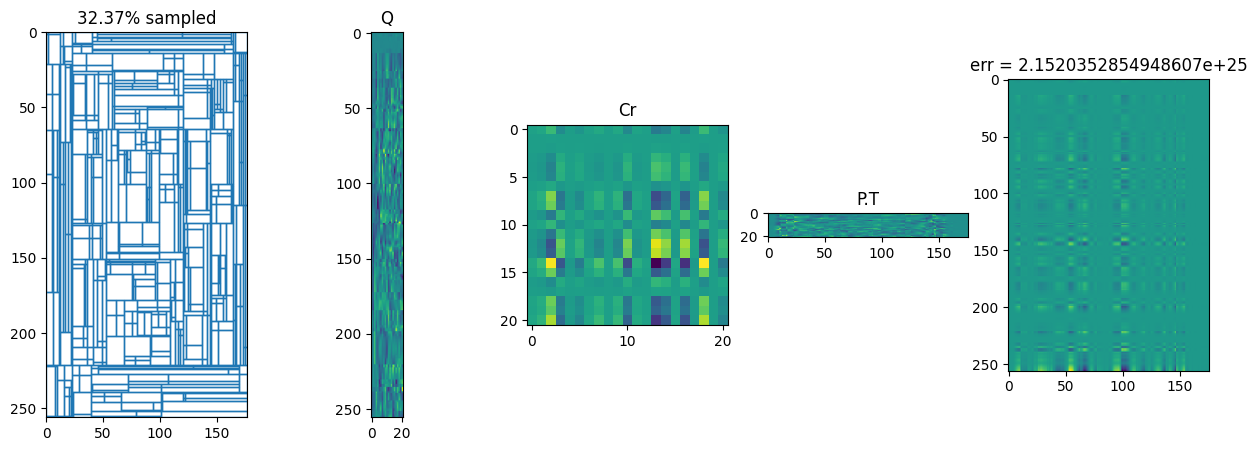

In [63]:
for j in range(1,251):
    root = Node(x=0, y=0, h=N[0], w=N[1])

    row_space = np.arange(N[0])
    col_space = np.arange(N[1])
    sampled_row = np.array([0,N[0]-1])
    sampled_col = np.array([0,N[1]-1])
    sad_row = np.zeros(N[0])
    sad_col = np.zeros(N[1])
    sad_row[sampled_row] = np.sum(np.abs(np.diff(A[sampled_row,:])),axis=1)/N[1]
    sad_col[sampled_col] = np.sum(np.abs(np.diff(A[:,sampled_col],axis=0)),axis=0)/N[0]

    f_row = interpolate.interp1d(sampled_row, sad_row[sampled_row])
    sad_row = f_row(np.arange(N[0]))
    p_row = sad_row
    p_row[sampled_row] = 0
    if np.sum(p_row) == 0:
        p_row = np.full_like(sad_row,1/N[0])
    else:
        p_row = p_row/np.sum(p_row)

    f_col = interpolate.interp1d(sampled_col, sad_col[sampled_col])
    sad_col = f_col(np.arange(N[1]))
    p_col = sad_col
    p_col[sampled_col] = 0
    if np.sum(p_col) == 0:
        p_col = np.full_like(sad_col,1/N[1])
    else:
        p_col = p_col/np.sum(p_col)

    k = 21
    s = 43

    Gamma = normal(size=(k,N[0]))
    Omega = normal(size=(N[1],k))
    Phi = normal(size=(s,N[0]))
    Psi = normal(size=(s,N[1]))

    for i in range(j):
        row = choice(row_space,1,replace=False,p=p_row)
        col = choice(col_space,1,replace=False,p=p_col)

        c = find_children(root)
        for n in c:
            if (n.y < row) & (row < n.y + n.h) & (n.x < col) & (col < n.x + n.w):
                _ = n(x = (col - n.x)/n.w, y = (row - n.y)/n.h)

                sad_row[row] = np.sum(np.abs(np.diff(A[row,n.x:n.x+n.w])),axis=1)/n.w
                sad_col[col] = np.sum(np.abs(np.diff(A[n.y:n.y+n.h,col],axis=0)),axis=0)/n.h

                f_row = interpolate.interp1d(sampled_row, sad_row[sampled_row])
                sad_row = f_row(np.arange(N[0]))
                p_row = sad_row
                p_row[sampled_row] = 0
                if np.sum(p_row) == 0:
                    p_row = np.full_like(sad_row,1/N[0])
                else:
                    p_row = p_row/np.sum(p_row)

                f_col = interpolate.interp1d(sampled_col, sad_col[sampled_col])
                sad_col = f_col(np.arange(N[1]))
                p_col = sad_col
                p_col[sampled_col] = 0
                if np.sum(p_col) == 0:
                    p_col = np.full_like(sad_col,1/N[1])
                else:
                    p_col = p_col/np.sum(p_col)

                if i == 0:
                    X = Gamma[:,sampled_row] @ A[sampled_row,:]
                    Y = A[:,sampled_col] @ Omega[sampled_col,:]
                    Z = Phi[:,sampled_row] @ A[np.ix_(sampled_row,sampled_col)] @ Psi[:,sampled_col].T
                    sampled_size = A[sampled_row,:].size + A[:,sampled_col].size -  A[np.ix_(sampled_row,sampled_col)].size
                else:
                    X[:,n.x:n.x+n.w] += Gamma[:,row] @ A[row,n.x:n.x+n.w] 
                    Y[n.y:n.y+n.h,:] += A[n.y:n.y+n.h,col] @ Omega[col,:]
                    Z += A[row,col] * Phi[:,row] @ Psi[:,col].T
                    sampled_size += n.w + n.h -  1    
                break

    P, _ = qr(np.array(X.T))
    Q, _ = qr(np.array(Y))

    C = pinv(Phi[:,sampled_row] @ Q[sampled_row,:]).dot(Z).dot(pinv(Psi[:,sampled_col] @ P[sampled_col,:]).T)
    U, s, VT = svd(C)
    Cr = U[:,:r].dot(np.diag(s[:r])).dot(VT[:r,:])

    Ar = Q.dot(Cr).dot(P.T)
    err = norm(A - Ar)**2 / norm(A)**2

    if j % 50 == 0:
        fig, ax = plt.subplots(1,5,figsize=[15,5])
        
        c = find_children(root)
        for n in c:
            rect = patches.Rectangle(
                (n.x, n.y),
                n.w,
                n.h,
                linewidth=1,
                edgecolor="C0",
                facecolor="none",
            )
            ax[0].add_patch(rect)
        ax[0].set_xlim(0, N[1])
        ax[0].set_ylim(N[0], 0)
        ax[0].set_title(f'{np.round(100*sampled_size/A.size,2)}% sampled')

        ax[1].imshow(Q)
        ax[1].set_title('Q')
        ax[2].imshow(Cr)
        ax[2].set_title('Cr')
        ax[3].imshow(P.T)
        ax[3].set_title('P.T')
        ax[4].imshow(Ar)
        ax[4].set_title(f'err = {np.round(err,2)}')
        plt.show()

In [35]:
u, s, v = svd(A)

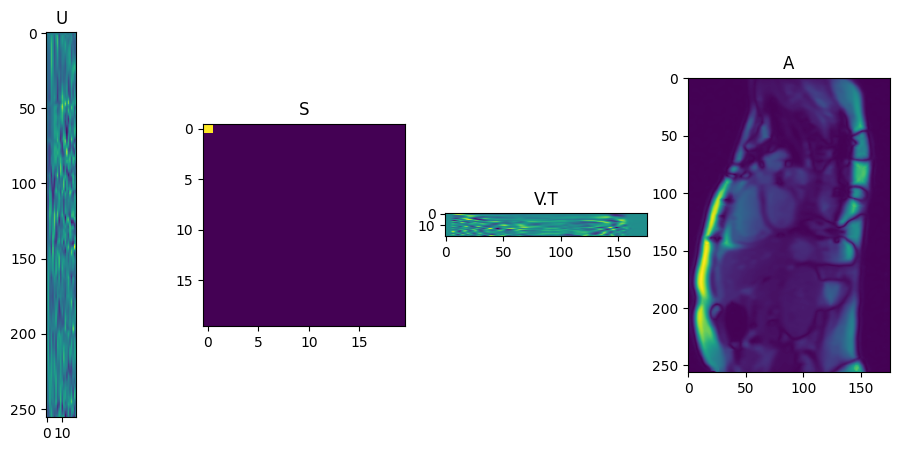

In [58]:
fig, ax = plt.subplots(1,4,figsize=[12,5])
ax[0].imshow(u[:,:r])
ax[0].set_title('U')
ax[1].imshow(np.diag(s[:r]))
ax[1].set_title('S')
ax[2].imshow(v[:r])
ax[2].set_title('V.T')
ax[3].imshow(A)
ax[3].set_title('A')
plt.show()